In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Add, Layer
from tensorflow.keras.callbacks import History
import matplotlib.pyplot as plt
import re

# required packages:
# pip install pandas numpy tensorflow transformers matplotlib 


c:\Users\himan\miniconda3\envs\colabenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # Ensure TensorFlow is using the GPU
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# physical_devices = tf.config.list_physical_devices('GPU')
# # if len(physical_devices) > 0:
# #     tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Load the captions file
captions_file = './flickr30k/captions.txt'
captions = pd.read_csv(captions_file)
captions.columns = ['image', 'caption']

captions.head()



image                                            caption
0  1000092795.jpg   Two young guys with shaggy hair look at their...
1  1000092795.jpg   Two young , White males are outside near many...
2  1000092795.jpg   Two men in green shirts are standing in a yard .
3  1000092795.jpg       A man in a blue shirt standing in a garden .
4  1000092795.jpg            Two friends enjoy time spent together .

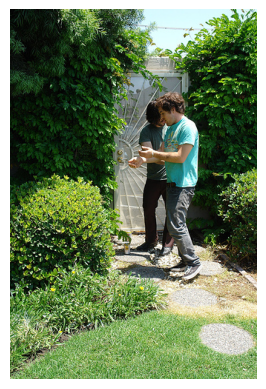

In [3]:
# better to use this function to display images
def display_image(image_path):
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

display_image('./flickr30k/Images/1000092795.jpg')



In [4]:
# preprocessing is very important for the text captions 
def text_preprocessing(data):
    # Convert to string and handle NaN values
    data['caption'] = data['caption'].astype(str).fillna('')
    
    # Convert to lowercase
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    
    # Remove non-alphabetical characters
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'[^a-z]', ' ', x))
    
    # Replace multiple spaces with a single space
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'\s+', ' ', x))
    
    # Remove single-character words
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    
    # Add startseq and endseq tokens
    data['caption'] = data['caption'].apply(lambda x: f"startseq {x.strip()} endseq")
    
    return data

captions = text_preprocessing(captions)

captions.head()

image                                            caption
0  1000092795.jpg  startseq two young guys with shaggy hair look ...
1  1000092795.jpg  startseq two young white males are outside nea...
2  1000092795.jpg  startseq two men in green shirts are standing ...
3  1000092795.jpg  startseq man in blue shirt standing in garden ...
4  1000092795.jpg  startseq two friends enjoy time spent together...

In [6]:
# # Create a dictionary to map images to their captions
# captions_dict = {}
# for idx, row in captions.iterrows():
#     img, caption = row['image'], row['caption']
#     if img not in captions_dict:
#         captions_dict[img] = []
#     captions_dict[img].append(caption)

# Sample 500 entries from the dataset
captions_sample = captions.sample(n=5000, random_state=42).reset_index(drop=True)

# Create a dictionary to map images to their captions
captions_dict = {}
for idx, row in captions_sample.iterrows():
    img, caption = row['image'], row['caption']
    if img not in captions_dict:
        captions_dict[img] = []
    captions_dict[img].append(caption)

print(len(captions_dict))



4693


In [7]:
# Split the data into training and validation sets
train_images, val_images = train_test_split(list(captions_dict.keys()), test_size=0.2, random_state=42)

# Tokenize the captions
all_captions = [caption for captions in captions_dict.values() for caption in captions]

print(len(all_captions))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# Define the vocabulary size and maximum caption length
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)

print(f"Vocabulary size: {vocab_size}")
print(f"Maximum caption length: {max_length}")


5000
Vocabulary size: 4513
Maximum caption length: 43


In [8]:
# below is the function to encode the captions
def encode_captions(captions):
    sequences = tokenizer.texts_to_sequences(captions)
    return pad_sequences(sequences, maxlen=max_length, padding='post')

# Encode the captions for the training and validation sets

train_captions = {img: encode_captions(captions_dict[img]) for img in train_images}
val_captions = {img: encode_captions(captions_dict[img]) for img in val_images}

print(train_captions[train_images[0]].shape)
print(val_captions[val_images[0]].shape)


(1, 43)
(1, 43)


In [9]:
# using efficient net b4 model for feature extraction 
base_model = tf.keras.applications.EfficientNetB4(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

model_extract = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

# Extract features for a single image
def extract_features(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    features = model_extract.predict(img, verbose=1)
    return features

# Extract features for all images
train_features = {img: extract_features(os.path.join('./flickr30k/Images', img)) for img in train_images}
val_features = {img: extract_features(os.path.join('./flickr30k/Images', img)) for img in val_images}



1/1 [==============================] - 0s 32ms/step


In [10]:
# # Load BERT model and tokenizer 
# bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# # Define a function to encode text using BERT
# def bert_encode(texts):
#     inputs = bert_tokenizer(texts, return_tensors="tf", padding=True, truncation=True, max_length=max_length)
#     outputs = bert_model(inputs)
#     return outputs.last_hidden_state

# # Encode captions using BERT
# train_bert_features = {img: bert_encode(captions_dict[img]) for img in train_images}
# val_bert_features = {img: bert_encode(captions_dict[img]) for img in val_images}

# print(train_bert_features[train_images[0]].shape)
# print(val_bert_features[val_images[0]].shape)

from transformers import DistilBertTokenizer, TFDistilBertModel


distil_bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

distil_bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Define a function to encode text using DistilBERT
def distil_bert_encode(texts):
    inputs = distil_bert_tokenizer(texts, return_tensors="tf", padding=True, truncation=True, max_length=max_length)
    outputs = distil_bert_model(inputs)
    return outputs.last_hidden_state

# Encode captions using DistilBERT
train_distil_bert_features = {img: distil_bert_encode(captions_dict[img]) for img in train_images}

val_distil_bert_features = {img: distil_bert_encode(captions_dict[img]) for img in val_images}

print(train_distil_bert_features[train_images[0]].shape)
print(val_distil_bert_features[val_images[0]].shape)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


(1, 15, 768)
(1, 17, 768)


In [11]:
class AttentionLayer(Layer):
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.units = units
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

# above attention layer is used to focus on the important parts of the image and the text caption
# above one is good but we can use the below one for better results

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights
    
# above one is the Bahdanau attention layer which is better because it uses the hidden state of the LSTM layer to focus on the important parts of the image and the text caption compared to the previous one which uses the hidden state of the LSTM layer to focus on the important parts of the image only no
    

In [23]:
units = 256


# Define the model
def build_model(vocab_size, max_length):
    # extract the shape of the features from the first image
    image_input = Input(shape=(train_features[train_images[0]].shape[1],)) 

    
    img_features = Dense(units, activation='relu')(image_input) 

    # Add an extra dimension to the features
    img_features = tf.expand_dims(img_features, 1)

    text_input = Input(shape=(max_length,))
    text_features = Embedding(vocab_size, units)(text_input)
    text_features = LSTM(units, return_sequences=True)(text_features)

    # increased the number of units in the attention layer 
    # attention_layer = AttentionLayer(units)
    attention_layer = BahdanauAttention(units)
    context_vector, _ = attention_layer(img_features, text_features[:, -1, :])
    combined_features = Add()([context_vector, text_features[:, -1, :]])

    output = Dense(vocab_size, activation='softmax')(combined_features)

    model = Model(inputs=[image_input, text_input], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

model = build_model(vocab_size, max_length)
model.summary()






Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1792)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 43, 256)      1155328     ['input_7[0][0]']                
                                                                                                  
 dense_13 (Dense)               (None, 256)          459008      ['input_6[0][0]']                
                                                                                            

Epoch 1/15
117/117 [==============================] - 18s 134ms/step - loss: 2.4188 - val_loss: 1.6405
Epoch 2/15
117/117 [==============================] - 15s 130ms/step - loss: 1.6036 - val_loss: 1.5473
Epoch 3/15
117/117 [==============================] - 15s 130ms/step - loss: 1.4900 - val_loss: 1.4859
Epoch 4/15
117/117 [==============================] - 15s 130ms/step - loss: 1.4101 - val_loss: 1.4470
Epoch 5/15
117/117 [==============================] - 15s 131ms/step - loss: 1.3412 - val_loss: 1.4211
Epoch 6/15
117/117 [==============================] - 15s 130ms/step - loss: 1.2730 - val_loss: 1.4071
Epoch 7/15
117/117 [==============================] - 15s 132ms/step - loss: 1.2105 - val_loss: 1.4057
Epoch 8/15
117/117 [==============================] - 15s 131ms/step - loss: 1.1513 - val_loss: 1.4099
Epoch 9/15
117/117 [==============================] - 15s 131ms/step - loss: 1.0956 - val_loss: 1.4206
Epoch 10/15
117/117 [==============================] - 15s 131ms/step - l

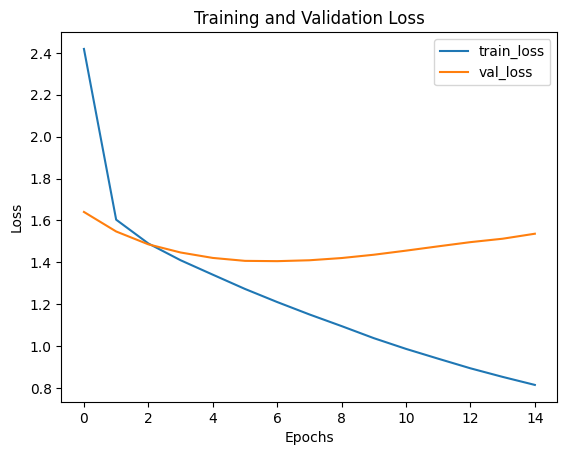

In [24]:
# Create a callback to store the history of loss during training
history = History()

# Prepare data for training
def data_generator(features, captions, batch_size):
    n = len(captions)
    while True:
        for i in range(0, n, batch_size):
            batch_images = list(features.keys())[i:i+batch_size]
            batch_features = [features[img][0] for img in batch_images]
            batch_captions = [captions[img] for img in batch_images]
            x1, x2, y = [], [], []
            for j, img_features in enumerate(batch_features):
                for caption in batch_captions[j]:
                    seq = caption
                    for k in range(1, len(seq)):
                        in_seq, out_seq = seq[:k], seq[k]
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]
                        x1.append(img_features)
                        x2.append(in_seq)
                        y.append(out_seq)
            yield [np.array(x1), np.array(x2)], np.array(y)

# Define the batch size and steps per epoch

batch_size = 32
steps_per_epoch = len(train_captions) // batch_size
validation_steps = len(val_captions) // batch_size

train_data = data_generator(train_features, train_captions, batch_size)
val_data = data_generator(val_features, val_captions, batch_size)

# Train the model with history tracking
history = model.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    validation_data=val_data,
    validation_steps=validation_steps,
    callbacks=[history]
)



# Plot the training and validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_loss(history)



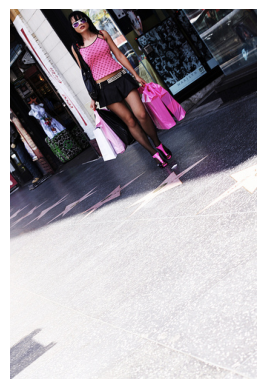

1/1 [==============================] - 0s 47ms/step
Extracted features shape: (1, 1792)
Current caption: startseq dog
Current caption: startseq dog is
Current caption: startseq dog is running
Current caption: startseq dog is running through
Current caption: startseq dog is running through the
Current caption: startseq dog is running through the ocean
dog is running through the ocean



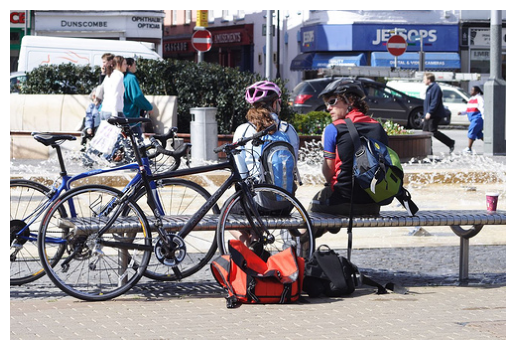

1/1 [==============================] - 0s 46ms/step
Extracted features shape: (1, 1792)
Current caption: startseq woman
Current caption: startseq woman in
Current caption: startseq woman in red
Current caption: startseq woman in red hat
Current caption: startseq woman in red hat and
Current caption: startseq woman in red hat and blue
Current caption: startseq woman in red hat and blue hat
Current caption: startseq woman in red hat and blue hat and
Current caption: startseq woman in red hat and blue hat and blue
Current caption: startseq woman in red hat and blue hat and blue hat
Current caption: startseq woman in red hat and blue hat and blue hat and
Current caption: startseq woman in red hat and blue hat and blue hat and blue
Current caption: startseq woman in red hat and blue hat and blue hat and blue hat
Current caption: startseq woman in red hat and blue hat and blue hat and blue hat and
Current caption: startseq woman in red hat and blue hat and blue hat and blue hat and blue
Curr

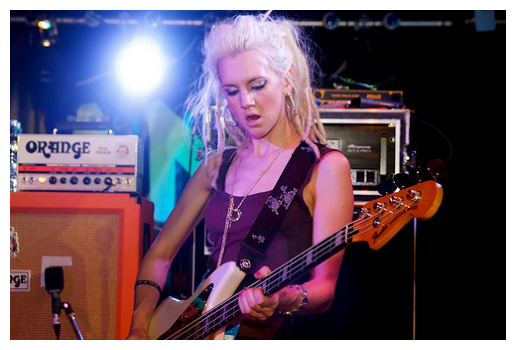

1/1 [==============================] - 0s 32ms/step
Extracted features shape: (1, 1792)
Current caption: startseq man
Current caption: startseq man in
Current caption: startseq man in white
Current caption: startseq man in white shirt
Current caption: startseq man in white shirt is
Current caption: startseq man in white shirt is looking
Current caption: startseq man in white shirt is looking at
Current caption: startseq man in white shirt is looking at the
Current caption: startseq man in white shirt is looking at the street
man in white shirt is looking at the street



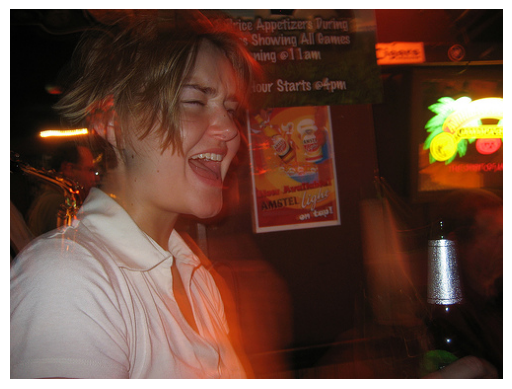

1/1 [==============================] - 0s 45ms/step
Extracted features shape: (1, 1792)
Current caption: startseq woman
Current caption: startseq woman in
Current caption: startseq woman in black
Current caption: startseq woman in black shirt
Current caption: startseq woman in black shirt is
Current caption: startseq woman in black shirt is about
Current caption: startseq woman in black shirt is about to
Current caption: startseq woman in black shirt is about to hit
Current caption: startseq woman in black shirt is about to hit the
Current caption: startseq woman in black shirt is about to hit the camera
woman in black shirt is about to hit the camera



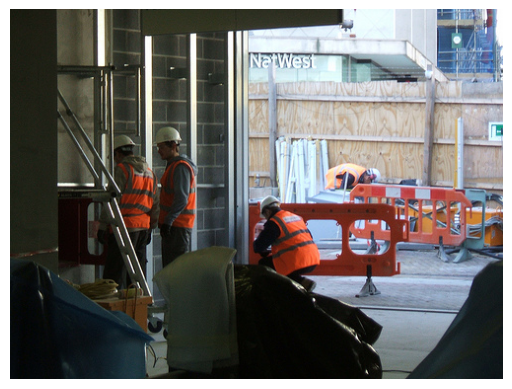

1/1 [==============================] - 0s 41ms/step
Extracted features shape: (1, 1792)
Current caption: startseq man
Current caption: startseq man in
Current caption: startseq man in white
Current caption: startseq man in white shirt
Current caption: startseq man in white shirt and
Current caption: startseq man in white shirt and white
Current caption: startseq man in white shirt and white shirt
Current caption: startseq man in white shirt and white shirt is
Current caption: startseq man in white shirt and white shirt is walking
Current caption: startseq man in white shirt and white shirt is walking down
Current caption: startseq man in white shirt and white shirt is walking down the
Current caption: startseq man in white shirt and white shirt is walking down the street
man in white shirt and white shirt is walking down the street



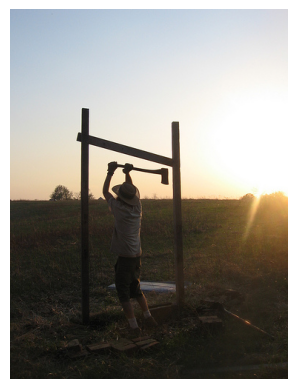

1/1 [==============================] - 0s 47ms/step
Extracted features shape: (1, 1792)
Current caption: startseq woman
Current caption: startseq woman wearing
Current caption: startseq woman wearing red
Current caption: startseq woman wearing red snowsuit
Current caption: startseq woman wearing red snowsuit downs
Current caption: startseq woman wearing red snowsuit downs top
Current caption: startseq woman wearing red snowsuit downs top is
Current caption: startseq woman wearing red snowsuit downs top is jumping
Current caption: startseq woman wearing red snowsuit downs top is jumping down
Current caption: startseq woman wearing red snowsuit downs top is jumping down the
Current caption: startseq woman wearing red snowsuit downs top is jumping down the street
woman wearing red snowsuit downs top is jumping down the street



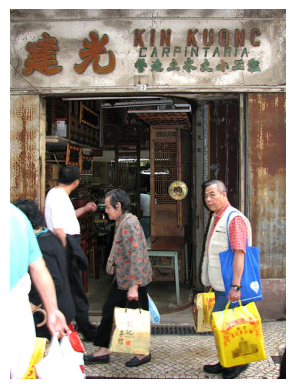

1/1 [==============================] - 0s 46ms/step
Extracted features shape: (1, 1792)
Current caption: startseq man
Current caption: startseq man in
Current caption: startseq man in blue
Current caption: startseq man in blue jacket
Current caption: startseq man in blue jacket and
Current caption: startseq man in blue jacket and blue
Current caption: startseq man in blue jacket and blue jacket
Current caption: startseq man in blue jacket and blue jacket and
Current caption: startseq man in blue jacket and blue jacket and blue
Current caption: startseq man in blue jacket and blue jacket and blue jacket
Current caption: startseq man in blue jacket and blue jacket and blue jacket and
Current caption: startseq man in blue jacket and blue jacket and blue jacket and blue
Current caption: startseq man in blue jacket and blue jacket and blue jacket and blue jacket
Current caption: startseq man in blue jacket and blue jacket and blue jacket and blue jacket and
Current caption: startseq man in 

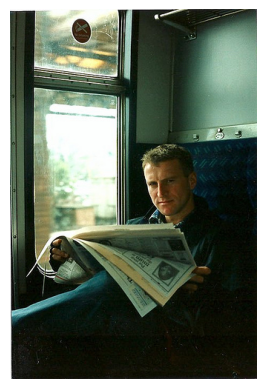

1/1 [==============================] - 0s 41ms/step
Extracted features shape: (1, 1792)
Current caption: startseq woman
Current caption: startseq woman in
Current caption: startseq woman in black
Current caption: startseq woman in black shirt
Current caption: startseq woman in black shirt and
Current caption: startseq woman in black shirt and black
Current caption: startseq woman in black shirt and black shirt
Current caption: startseq woman in black shirt and black shirt and
Current caption: startseq woman in black shirt and black shirt and black
Current caption: startseq woman in black shirt and black shirt and black shirt
Current caption: startseq woman in black shirt and black shirt and black shirt and
Current caption: startseq woman in black shirt and black shirt and black shirt and black
Current caption: startseq woman in black shirt and black shirt and black shirt and black shirt
Current caption: startseq woman in black shirt and black shirt and black shirt and black shirt and
C

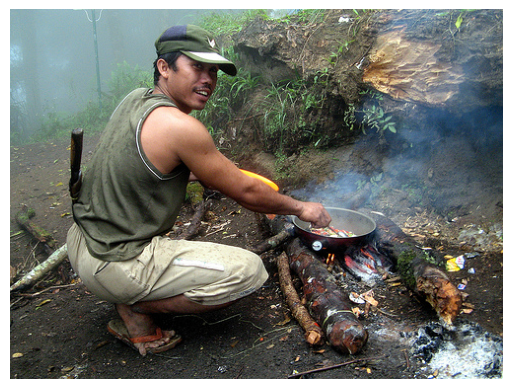

1/1 [==============================] - 0s 41ms/step
Extracted features shape: (1, 1792)
Current caption: startseq woman
Current caption: startseq woman in
Current caption: startseq woman in blue
Current caption: startseq woman in blue shirt
Current caption: startseq woman in blue shirt and
Current caption: startseq woman in blue shirt and blue
Current caption: startseq woman in blue shirt and blue shirt
Current caption: startseq woman in blue shirt and blue shirt and
Current caption: startseq woman in blue shirt and blue shirt and blue
Current caption: startseq woman in blue shirt and blue shirt and blue shirt
Current caption: startseq woman in blue shirt and blue shirt and blue shirt and
Current caption: startseq woman in blue shirt and blue shirt and blue shirt and blue
Current caption: startseq woman in blue shirt and blue shirt and blue shirt and blue shirt
Current caption: startseq woman in blue shirt and blue shirt and blue shirt and blue shirt and
Current caption: startseq woman

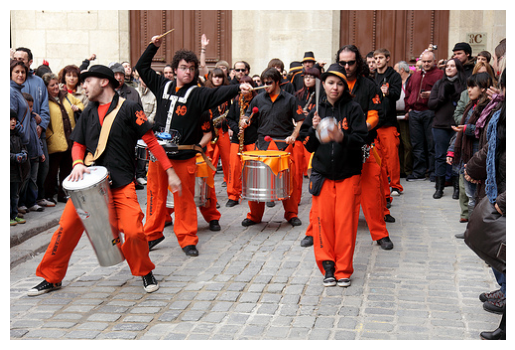

1/1 [==============================] - 0s 41ms/step
Extracted features shape: (1, 1792)
Current caption: startseq woman
Current caption: startseq woman in
Current caption: startseq woman in black
Current caption: startseq woman in black shirt
Current caption: startseq woman in black shirt and
Current caption: startseq woman in black shirt and black
Current caption: startseq woman in black shirt and black and
Current caption: startseq woman in black shirt and black and black
Current caption: startseq woman in black shirt and black and black and
Current caption: startseq woman in black shirt and black and black and black
Current caption: startseq woman in black shirt and black and black and black and
Current caption: startseq woman in black shirt and black and black and black and black
Current caption: startseq woman in black shirt and black and black and black and black dog
Current caption: startseq woman in black shirt and black and black and black and black dog is
Current caption: sta

In [25]:
def generate_caption(image_path):
    try:
        # Extract image features
        features = extract_features(image_path)
        print(f"Extracted features shape: {features.shape}")

        # Initialize the caption with the start sequence
        in_text = 'startseq'

        # Generate the caption word by word
        for i in range(max_length):
            # Convert the current caption to a sequence of integers
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            # Pad the sequence to the maximum length
            sequence = pad_sequences([sequence], maxlen=max_length)

            # Predict the next word
            yhat = model.predict([features, sequence], verbose=0)
            # Get the index of the word with the highest probability
            yhat = np.argmax(yhat)
            # Get the word corresponding to the index
            word = tokenizer.index_word.get(yhat, '')

            # If the word is None or end of sequence token, break the loop
            if word is None or word == 'endseq':
                break

            # Append the word to the current caption
            in_text += ' ' + word
            print(f"Current caption: {in_text}")

        # Remove the start and end sequence tokens from the caption
        final_caption = in_text.split()[1:]
        # Join the words to form the final caption
        final_caption = ' '.join(final_caption)
        # print(f"Final caption: {final_caption}")

        return final_caption

    except Exception as e:
        print(f"Error: {e}")
        return ""



# Generate caption for a new image
# print(generate_caption('./flickr30k/Images/36979.jpg'))
# print(generate_caption('./flickr30k/Images/8247042603.jpg'))

# Generate caption for a new image
for i in range(10):
    img_path = f'./flickr30k/Images/{val_images[i]}'
    display_image(img_path)
    print(generate_caption(img_path))
    print()

